In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('/content/raw_house_data.csv')
df['HOA'] = df['HOA'].str.replace(',','')

df['HOA'] = df['HOA'].astype(float)

median_lot_acres = df['lot_acres'].median()
df['lot_acres'] = df['lot_acres'].fillna(median_lot_acres)

median_bathrooms = df['bathrooms'].median()
df['bathrooms'] = df['bathrooms'].fillna(median_bathrooms)

median_sqrt_ft = df['sqrt_ft'].median()
df['sqrt_ft'] = df['sqrt_ft'].fillna(median_sqrt_ft)

median_garage = df['garage'].median()
df['garage'] = df['garage'].fillna(median_garage)


df['kitchen_features'] = df['kitchen_features'].fillna('missing')


df['floor_covering'] = df['floor_covering'].fillna('missing')


median_HOA = df['HOA'].median()
df['HOA'] = df['HOA'].fillna(median_HOA)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   MLS               5000 non-null   int64  
 1   sold_price        5000 non-null   float64
 2   zipcode           5000 non-null   int64  
 3   longitude         5000 non-null   float64
 4   latitude          5000 non-null   float64
 5   lot_acres         5000 non-null   float64
 6   taxes             5000 non-null   float64
 7   year_built        5000 non-null   int64  
 8   bedrooms          5000 non-null   int64  
 9   bathrooms         5000 non-null   float64
 10  sqrt_ft           5000 non-null   float64
 11  garage            5000 non-null   float64
 12  kitchen_features  5000 non-null   object 
 13  fireplaces        5000 non-null   object 
 14  floor_covering    5000 non-null   object 
 15  HOA               5000 non-null   float64
dtypes: float64(9), int64(4), object(3)
memory 

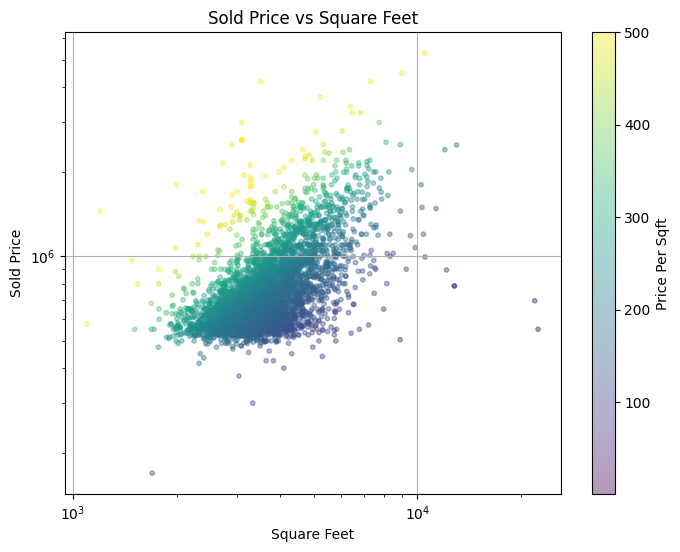

In [ ]:
df["price_per_sqft"] = df["sold_price"] / df["sqrt_ft"]
plt.figure(figsize=(8, 6))
scatter = plt.scatter(df["sqrt_ft"], df['sold_price'], c = df["price_per_sqft"], cmap = "viridis", alpha = .4,s=10, vmin = 0.7, vmax = 500)
plt.colorbar(scatter, label = 'Price Per Sqft')
plt.xlabel("Square Feet")
plt.ylabel("Sold Price")
plt.title("Sold Price vs Square Feet")
plt.xscale("log")
plt.yscale("log")
plt.grid(True)
plt.show()

In [ ]:
df["price_per_sqft"] = df["sold_price"] / df["sqrt_ft"]
# create 10 equal-sized bins (deciles)
df["cat"], bin_edges = pd.qcut(
    df["price_per_sqft"],
    q=10,
    labels=False,
    retbins=True,
    duplicates="drop"
)

df["cat"] = df["cat"].astype(int)
print("Decile bins:", bin_edges)
print(df["cat"].value_counts().sort_index())


Decile bins: [  24.54480543  153.50292032  169.14580254  180.51691012  191.52491249
  202.09676579  213.04243633  225.50565728  242.92349391  275.25577743
 1208.33333333]
cat
0    500
1    500
2    500
3    500
4    500
5    500
6    500
7    500
8    500
9    500
Name: count, dtype: int64


In [ ]:
def kmeans_custom(X, k, max_iters=100):
    # X is (n_samples, 2) for latitude and longitude
    n = X.shape[0]

    # randomly choose k initial centers
    idx = np.random.choice(n, k, replace=False)
    centers = X[idx]

    for _ in range(max_iters):
        # assign points to closest cluster
        dists = np.sqrt(((X[:, None, :] - centers[None, :, :])**2).sum(axis=2))
        labels = np.argmin(dists, axis=1)

        # recompute centers
        new_centers = np.array([
            X[labels == i].mean(axis=0) if np.any(labels == i) else centers[i]
            for i in range(k)
        ])

        # stop when centers converge
        if np.allclose(centers, new_centers, atol=1e-4):
            break

        centers = new_centers

    return labels, centers



In [ ]:
coords = df[["latitude", "longitude"]].to_numpy()

labels, centers = kmeans_custom(coords, k=5)
labels[:10]


array([2, 2, 2, 2, 1, 1, 1, 1, 1, 1])

In [ ]:
def cluster_inertia(X, labels, centers):
    return ((X - centers[labels])**2).sum()

results = {}

for k in range(5, 26):
    labels_k, centers_k = kmeans_custom(coords, k)
    inertia_k = cluster_inertia(coords, labels_k, centers_k)
    results[k] = inertia_k

best_k = min(results, key=results.get)
best_k


21

In [ ]:
best_labels, best_centers = kmeans_custom(coords, best_k)

df["region"] = best_labels + 50   # region IDs from 50 upward


#Model 1

In [ ]:
# features for classifier
X1 = df[["latitude", "longitude", "region"]].to_numpy()
y1 = df["cat"].to_numpy()

# normalize once
X1_mean = X1.mean(axis=0)
X1_std = X1.std(axis=0)
X1_norm = (X1 - X1_mean) / X1_std

# shuffle
indices = np.arange(len(X1_norm))
np.random.shuffle(indices)
X1_norm = X1_norm[indices]
y1 = y1[indices]

# split
split = int(0.8 * len(X1_norm))
X1_train = X1_norm[:split]
X1_test = X1_norm[split:]
y1_train = y1[:split]
y1_test = y1[split:]

In [ ]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b)**2))

In [ ]:
def knn_predict(X_train, y_train, x, k=5):
    # compute distances from x to all points
    distances = np.sqrt(np.sum((X_train - x)**2, axis=1))

    # get k nearest indices
    nn_indices = np.argpartition(distances, k)[:k]

    # get classes
    nn_classes = y_train[nn_indices]

    # majority vote
    values, counts = np.unique(nn_classes, return_counts=True)
    return values[np.argmax(counts)]


In [ ]:
correct = 0

for i in range(len(X1_test)):
    pred = knn_predict(X1_train, y1_train, X1_test[i], k=7)
    if pred == y1_test[i]:
        correct += 1

accuracy = correct / len(X1_test)
print("Model 1 KNN Classifier accuracy:", accuracy)


Model 1 KNN Classifier accuracy: 0.197


In [ ]:
for k in [1, 3, 5, 7, 9, 11, 15, 21]:
    correct = 0
    for i in range(len(X1_test)):
        pred = knn_predict(X1_train, y1_train, X1_test[i], k=k)
        if pred == y1_test[i]:
            correct += 1
    acc = correct / len(X1_test)
    print("k =", k, "accuracy =", acc)


k = 1 accuracy = 0.192
k = 3 accuracy = 0.177
k = 5 accuracy = 0.185
k = 7 accuracy = 0.197
k = 9 accuracy = 0.192
k = 11 accuracy = 0.192
k = 15 accuracy = 0.186
k = 21 accuracy = 0.19


#Model 2

In [ ]:
# Features for Model 2
features = [
    "bedrooms",
    "bathrooms",
    "garage",
    "sqrt_ft",
    "taxes",
    "lot_acres",
    "HOA",
    "year_built",
    "region"
]

X2 = df[features].to_numpy().astype(float)
y2 = df["price_per_sqft"].to_numpy().astype(float)

# normalize features (critical for both linear reg and KNN)
X2_mean = X2.mean(axis=0)
X2_std = X2.std(axis=0)

X2_norm = (X2 - X2_mean) / X2_std

# shuffle
indices = np.arange(len(X2_norm))
np.random.shuffle(indices)

X2_norm = X2_norm[indices]
y2 = y2[indices]

# 80/20 split
split = int(0.8 * len(X2_norm))
X2_train = X2_norm[:split]
X2_test = X2_norm[split:]
y2_train = y2[:split]
y2_test = y2[split:]

print(X2_train.shape)
print(np.median(y2_train))


(4000, 9)
201.87506291538452


In [ ]:
def linear_regression_train(X, y, lr=0.01, epochs=500):
    n, d = X.shape
    # Initialize weights
    w = np.zeros(d)
    b = 0.0

    for epoch in range(epochs):
        # Predictions
        y_pred = X.dot(w) + b

        # Errors
        error = y_pred - y

        # Gradients
        dw = (1/n) * X.T.dot(error)
        db = (1/n) * np.sum(error)

        # Update
        w -= lr * dw
        b -= lr * db

    return w, b


In [ ]:
w_lin, b_lin = linear_regression_train(X2_train, y2_train, lr=0.01, epochs=800)
y_pred_lin = X2_test.dot(w_lin) + b_lin

# Metrics
mae_lin = np.mean(np.abs(y_pred_lin - y2_test))
rmse_lin = np.sqrt(np.mean((y_pred_lin - y2_test)**2))
mape_lin = np.mean(np.abs((y_pred_lin - y2_test) / y2_test)) * 100

print("Linear Regression MAE:", mae_lin)
print("Linear Regression RMSE:", rmse_lin)
print("Linear Regression MAPE:", mape_lin, "%")


Linear Regression MAE: 35.97289186158216
Linear Regression RMSE: 55.87720505502637
Linear Regression MAPE: 17.506037519961122 %


In [ ]:
def knn_regressor_predict(X_train, y_train, x, k=7):
    # Euclidean distances
    distances = np.sqrt(np.sum((X_train - x)**2, axis=1))
    # nearest neighbors
    nn_idx = np.argpartition(distances, k)[:k]
    return np.mean(y_train[nn_idx])


In [ ]:
for k in [1, 3, 5, 7, 9, 11, 15]:
    preds = []
    for i in range(len(X2_test)):
        preds.append(knn_regressor_predict(X2_train, y2_train, X2_test[i], k=k))
    preds = np.array(preds)

    mae = np.mean(np.abs(preds - y2_test))
    rmse = np.sqrt(np.mean((preds - y2_test)**2))
    mape = np.mean(np.abs((preds - y2_test) / y2_test)) * 100

    print("K =", k, "| MAE:", mae, "| RMSE:", rmse, "| MAPE:", mape, "%")


K = 1 | MAE: 36.25541333504789 | RMSE: 57.21342219327776 | MAPE: 17.523033548414226 %
K = 3 | MAE: 33.06191061153014 | RMSE: 54.15876108072334 | MAPE: 15.994657370976602 %
K = 5 | MAE: 32.44901222004874 | RMSE: 53.81991563235595 | MAPE: 15.630729195894816 %
K = 7 | MAE: 33.30266319281966 | RMSE: 55.811240327495085 | MAPE: 15.95744211759755 %
K = 9 | MAE: 32.97085406048842 | RMSE: 56.068131472998296 | MAPE: 15.793457498507502 %
K = 11 | MAE: 32.76702572259417 | RMSE: 55.10913475381162 | MAPE: 15.63047512663026 %
K = 15 | MAE: 32.897025966709016 | RMSE: 55.88262499810917 | MAPE: 15.657786815189365 %


In [ ]:
def predict_price(df_row):
    # df_row is a single row DataFrame with all original columns

    # extract features
    x = np.array([
        df_row["bedrooms"],
        df_row["bathrooms"],
        df_row["garage"],
        df_row["sqrt_ft"],
        df_row["taxes"],
        df_row["lot_acres"],
        df_row["HOA"],
        df_row["year_built"],
        df_row["region"]
    ], dtype=float)

    # normalize
    x_norm = (x - X2_mean) / X2_std

    # predict price per sqft using KNN (k=3)
    ppsqft = knn_regressor_predict(X2_train, y2_train, x_norm, k=3)

    # final price
    final_price = ppsqft * df_row["sqrt_ft"]

    return ppsqft, final_price


In [ ]:
sample = df.iloc[100]
price_sqft_pred, price_pred = predict_price(sample)

print("Predicted price per sqft:", price_sqft_pred)
print("Predicted sale price:", price_pred)
print("Actual sale price:", sample["sold_price"])


Predicted price per sqft: 288.0330639054949
Predicted sale price: 1945663.346681618
Actual sale price: 2100000.0


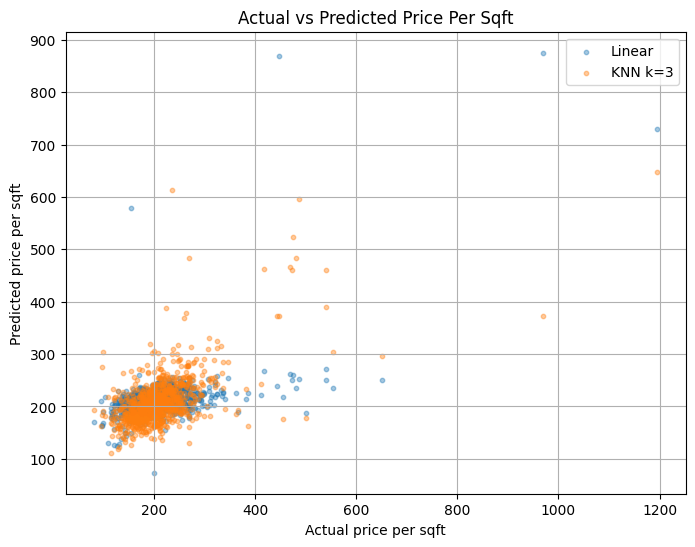

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(y2_test, y_pred_lin, alpha=0.4, s=10, label="Linear")
plt.scatter(y2_test, np.array([knn_regressor_predict(X2_train, y2_train, X2_test[i], k=3)
                               for i in range(len(X2_test))]),
            alpha=0.4, s=10, label="KNN k=3")

plt.xlabel("Actual price per sqft")
plt.ylabel("Predicted price per sqft")
plt.title("Actual vs Predicted Price Per Sqft")
plt.legend()
plt.grid(True)
plt.show()


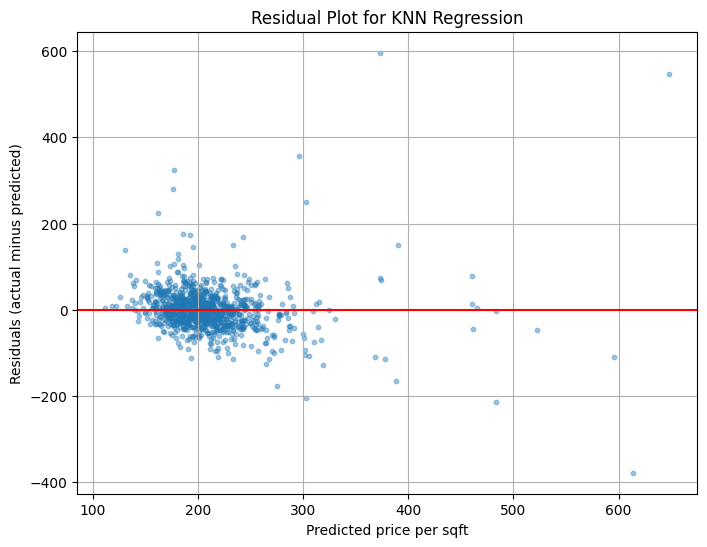

In [ ]:
# compute KNN predictions for the test set
knn_preds = np.array([
    knn_regressor_predict(X2_train, y2_train, X2_test[i], k=3)
    for i in range(len(X2_test))
])

residuals = y2_test - knn_preds

plt.figure(figsize=(8,6))
plt.scatter(knn_preds, residuals, alpha=0.4, s=10)
plt.axhline(0, color="red")
plt.xlabel("Predicted price per sqft")
plt.ylabel("Residuals (actual minus predicted)")
plt.title("Residual Plot for KNN Regression")
plt.grid(True)
plt.show()


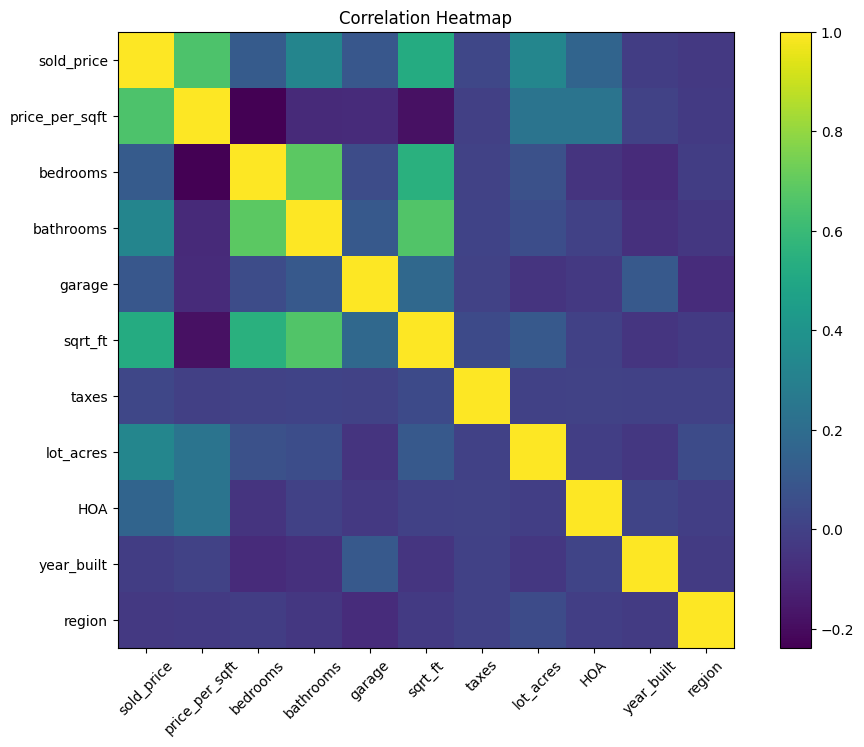

In [ ]:
corr_matrix = df[[
    "sold_price", "price_per_sqft", "bedrooms", "bathrooms", "garage",
    "sqrt_ft", "taxes", "lot_acres", "HOA", "year_built", "region"
]].corr()

plt.figure(figsize=(12,8))
plt.imshow(corr_matrix, cmap="viridis", interpolation="nearest")
plt.colorbar()
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45)
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title("Correlation Heatmap")
plt.show()


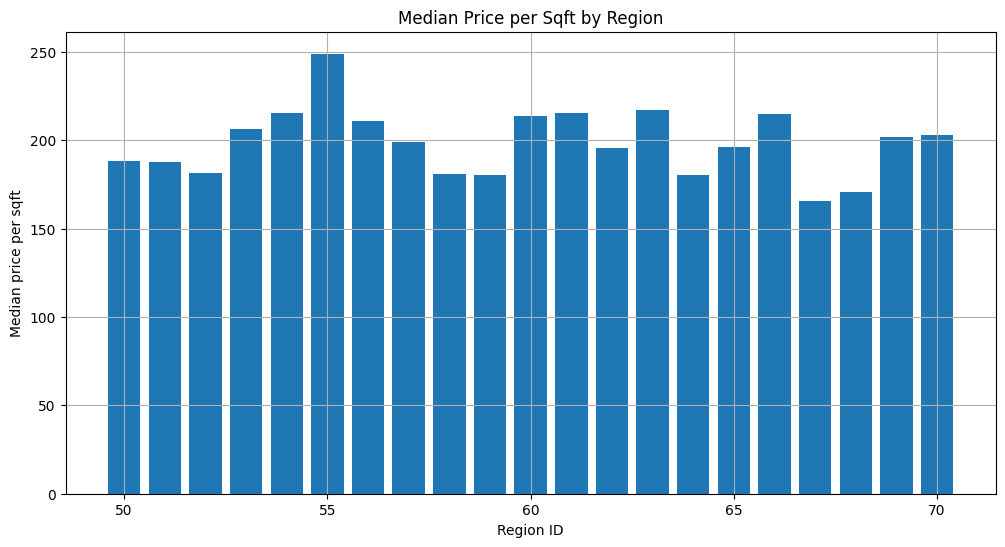

In [ ]:
plt.figure(figsize=(12,6))
region_medians = df.groupby("region")["price_per_sqft"].median()

plt.bar(region_medians.index, region_medians.values)
plt.xlabel("Region ID")
plt.ylabel("Median price per sqft")
plt.title("Median Price per Sqft by Region")
plt.grid(True)
plt.show()


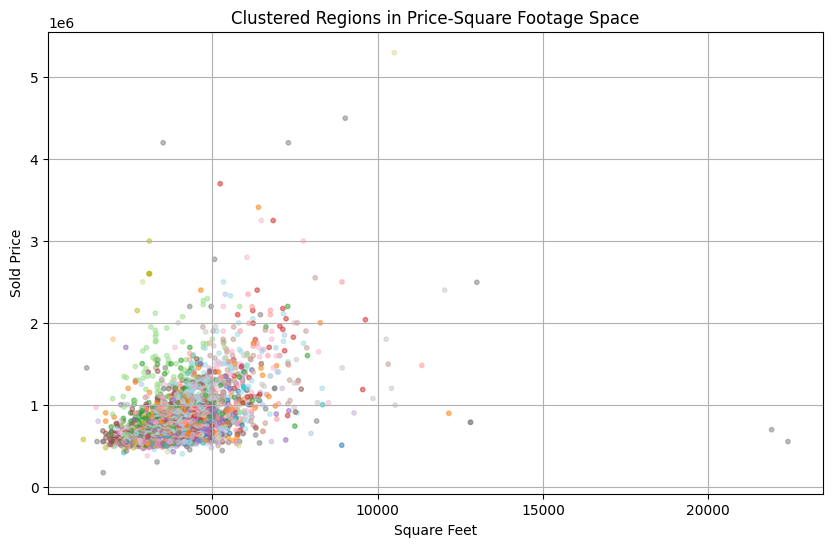

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(df["sqrt_ft"], df["sold_price"],
            c=df["region"], cmap="tab20", alpha=0.5, s=10)
plt.xlabel("Square Feet")
plt.ylabel("Sold Price")
plt.title("Clustered Regions in Price-Square Footage Space")
plt.grid(True)
plt.show()


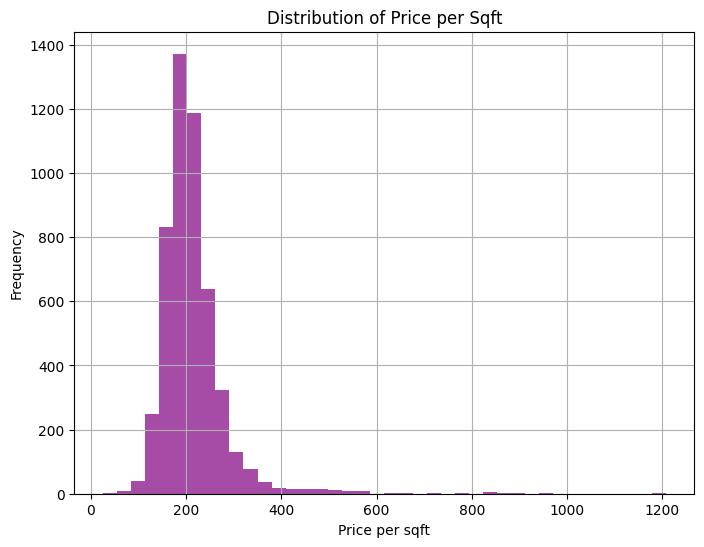

In [ ]:
plt.figure(figsize=(8,6))
plt.hist(df["price_per_sqft"], bins=40, color="purple", alpha=0.7)
plt.xlabel("Price per sqft")
plt.ylabel("Frequency")
plt.title("Distribution of Price per Sqft")
plt.grid(True)
plt.show()


In [ ]:
df

,MLS,sold_price,zipcode,longitude,latitude,lot_acres,taxes,year_built,bedrooms,bathrooms,sqrt_ft,garage,kitchen_features,fireplaces,floor_covering,HOA,price_per_sqft,cat,region
0,21530491,5300000.0,85637,-110.378200,31.356362,2154.00,5272.00,1941,13,10.0,10500.0,0.0,"Dishwasher, Freezer, Refrigerator, Oven",6,"Mexican Tile, Wood",0.0,504.761905,9,67
1,21529082,4200000.0,85646,-111.045371,31.594213,1707.00,10422.36,1997,2,2.0,7300.0,0.0,"Dishwasher, Garbage Disposal",5,"Natural Stone, Other",0.0,575.342466,9,64
2,3054672,4200000.0,85646,-111.040707,31.594844,1707.00,10482.00,1997,2,3.0,3512.0,3.0,"Dishwasher, Garbage Disposal, Refrigerator",5,"Natural Stone, Other: Rock",56.0,1195.899772,9,64
3,21919321,4500000.0,85646,-111.035925,31.645878,636.67,8418.58,1930,7,5.0,9019.0,4.0,"Dishwasher, Double Sink, Pantry: Butler, Refri...",4,"Ceramic Tile, Laminate, Wood",56.0,498.946668,9,64
4,21306357,3411450.0,85750,-110.813768,32.285162,3.21,15393.00,1995,4,6.0,6396.0,3.0,"Dishwasher, Garbage Disposal, Refrigerator, Mi...",5,"Carpet, Concrete",55.0,533.372420,9,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,21810382,495000.0,85641,-110.661829,31.907917,4.98,2017.00,2005,5,3.0,3601.0,3.0,"Dishwasher, Double Sink, Garbage Disposal, Gas...",1,"Carpet, Ceramic Tile",56.0,137.461816,0,68
4996,21908591,550000.0,85750,-110.858556,32.316373,1.42,4822.01,1990,4,3.0,2318.0,3.0,"Dishwasher, Double Sink, Electric Range, Garba...",1,"Carpet, Ceramic Tile",43.0,237.273512,7,57
4997,21832452,475000.0,85192,-110.755428,32.964708,12.06,1000.00,1969,3,2.0,1772.0,0.0,"Dishwasher, Electric Range, Island, Refrigerat...",0,Ceramic Tile,56.0,268.058691,8,66
4998,21900515,550000.0,85745,-111.055528,32.296871,1.01,5822.93,2009,4,4.0,3724.0,3.0,"Dishwasher, Double Sink, Garbage Disposal, Gas...",1,"Carpet, Ceramic Tile",56.0,147.690655,0,59
